In [1]:
import numpy as np
import pandas as pd

### Feature Evaluation

In [2]:
data = pd.read_csv('../Data/solar_data.csv')

In [3]:
data.tail()


,Date,Time,solar_output,temperature,humidity,wind_speed,visibility,serial
26095,30-03-17,17:40,3.19117,38.9,4.12,10.74,4.1,141
26096,30-03-17,17:45,2.75546,38.9,4.42,10.46,4.4,142
26097,30-03-17,17:50,2.35323,38.9,4.84,10.12,4.8,143
26098,30-03-17,17:55,1.98061,38.9,5.37,9.73,5.4,144
26099,30-03-17,18:00,1.59809,39.0,6.00,9.30,6.0,145


In [4]:
data.dtypes

Date             object
Time             object
solar_output    float64
temperature     float64
humidity        float64
wind_speed      float64
visibility      float64
serial            int64
dtype: object

In [5]:
#data['month']=data.Date.str.slice(-5,-3).astype(int).head() #String Slicing
data['month']=pd.to_datetime(data.Date,dayfirst=True).dt.month

In [6]:
data=data.drop(['Date','Time'],axis=1)
X = data.iloc[:,1:]
#Y = list(data.iloc[:,:1])
Y=data['solar_output']
#Y= np.asarray(data['solar_output'], dtype="int")

In [7]:
#X=X.values
X.head()

,temperature,humidity,wind_speed,visibility,serial,month
0,27.0,74.0,0.00,4.0,1,10
1,27.0,74.0,0.56,4.0,2,10
2,27.0,74.0,1.00,4.0,3,10
3,27.0,74.0,1.33,4.0,4,10
4,27.0,74.0,1.57,4.0,5,10


In [6]:
## Feature Selection 

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

#X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
#estimator = SVR(kernel="linear")
selector = RFE(rf, step=1)
selector = selector.fit(X, Y)



In [7]:
selector.ranking_

array([2, 1, 1, 3])

In [8]:
X.head()

,temperature,humidity,wind_speed,visibility
0,27.0,74.0,0.00,4.0
1,27.0,74.0,0.56,4.0
2,27.0,74.0,1.00,4.0
3,27.0,74.0,1.33,4.0
4,27.0,74.0,1.57,4.0


## Keras Model

In [8]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score

print(tf.__version__)

1.9.0


In [9]:
mean=X.mean(axis=0)
std=X.std(axis=0)

X=(X-mean)/std
#Y=(Y-mean)/std

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=40)

In [11]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu,
                       input_shape=(X.shape[1],)),
    
    keras.layers.Dense(128, activation=tf.nn.relu),
    
    keras.layers.Dense(128, activation=tf.nn.relu),
    
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),

      

    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               896       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total para

In [12]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

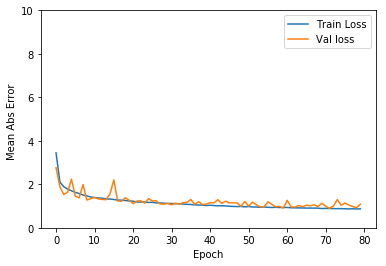

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error ')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 10])

plot_history(history)


................................................................................

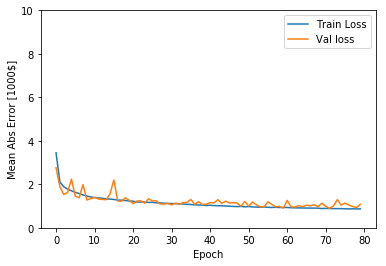

In [14]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [21]:
[loss, mae] = model.evaluate(X_test, y_test, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

Testing set Mean Abs Error: $1118.94


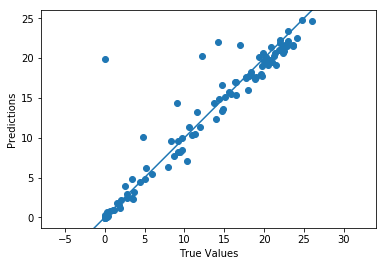

In [29]:
test_predictions = model.predict(X_test).flatten()

plt.scatter(y_test[500:600],test_predictions[500:600])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [20]:
from sklearn.metrics import r2_score
r2_score(y_test,test_predictions)

0.9498387169551984

In [17]:
saving = pd.DataFrame()
saving['Original']=y_test[:]
saving['Predicted']=test_predictions[:]
saving.to_csv('model_5L_Month+Time.csv')

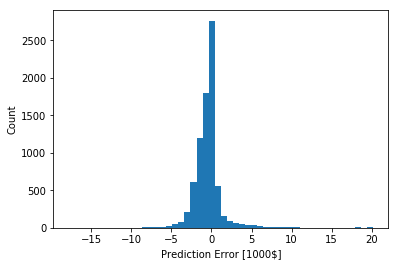

In [18]:
error = test_predictions - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [1000$]")
_ = plt.ylabel("Count")

### Evaluating with Random Forest Regressor

In [19]:
print(X_train.shape)
print(y_train.shape)

(18270, 4)
(18270,)


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

Y = sc.fit_transform(Y)

In [12]:
X1=X.drop(['visibility'],axis=1)

In [13]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X1, Y, test_size=0.3)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y, test_size=0.3,random_state=40)

rf = RandomForestRegressor()
rf.fit(X1_train, y1_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [18]:
# data_test = pd.read_csv('modified_test_interpolated.csv')
#data_test=data_test.drop(['Date','Time'],axis=1)
#X_test = data_test.iloc[:,1:]
#Y = list(data.iloc[:,:1])
#Y_test= np.asarray(data_test['solar_output'], dtype="float32")


,temperature,humidity,wind_speed,visibility,serial
14761,17.0,20.00,11.10,5.0,117
15964,8.2,76.00,8.22,3.0,15
2787,26.6,24.64,6.12,4.3,33
1630,26.7,51.09,13.07,5.9,36
19751,16.7,49.27,0.00,2.1,32


In [783]:
#test=pd.read_csv('test_interpolated.csv')
#test=test.drop(['Date','Time','visibility','wind_speed'],axis=1)
#X_TEST_NEW = test.iloc[:,1:]
#Y_TEST_NEW= np.asarray(test['solar_output'], dtype="int")

In [784]:
pred_NEW = rf.predict(X1_test)

In [785]:
## Scores R2
from sklearn.metrics import r2_score
r2_score(y1_test, pred_NEW) ## With Reduced Feature Set

0.93390808739603681

In [786]:
## Using K-FoldCross Validation
from sklearn.cross_validation import KFold
rf = RandomForestRegressor()
X1=X1.values
# Compute R2 using 10-fold x-validation
kf = KFold(len(X), n_folds=10)
xval_err = 0
for train,test in kf:
    rf.fit(X1[train],Y[train])
    p = rf.predict(X1[test])
    e = p-Y[test]
    xval_err += r2_score(Y[test], p)
rf_10cv = np.sqrt(xval_err/10)

method_name = 'Random Forest Regressor'
print('Method: %s' %method_name)

print('R2 on 10-fold CV: %.4f' %rf_10cv)

Method: Random Forest Regressor
R2 on 10-fold CV: 0.9014


In [791]:
data_test = pd.read_csv('modified_test_interpolated.csv')
data_test=data_test.drop(['Date','Time','visibility'],axis=1)
X_test = data_test.iloc[:,1:]
Y = list(data.iloc[:,:1])
Y_test= np.asarray(data_test['solar_output'], dtype="float32")

In [792]:
pre=rf.predict(X_test)

In [795]:
ab=pd.DataFrame({'original':Y_test,'Prediction_withoutVisibility':pre})

In [796]:
ab.to_csv('abc.csv')

## R2 Scores using ALL FEATURE SET

In [753]:
## Old R2 Score With all the Feature Set
rf = RandomForestRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=40)
rf.fit(X_train, y_train)
#test=pd.read_csv('test_interpolated.csv')
#test=test.drop(['Date','Time'],axis=1)
#X_TEST_OLD = test.iloc[:,1:]
#Y = list(data.iloc[:,:1])
#Y_TEST_OLD= np.asarray(test['solar_output'], dtype="int")
pred_OLD = rf.predict(X_test)
r2_score(y_test, pred_OLD)

0.94307881621930378

In [754]:
## Using K-FoldCross Validation
from sklearn.cross_validation import KFold
rf = RandomForestRegressor()
X=X.values
# Compute R2 using 10-fold x-validation
kf = KFold(len(X), n_folds=10)
xval_err = 0
for train,test in kf:
    rf.fit(X[train],Y[train])
    p = rf.predict(X[test])
    e = p-Y[test]
    xval_err += r2_score(Y[test], p)
rf_10cv = np.sqrt(xval_err/10)

method_name = 'Random Forest Regressor'
print('Method: %s' %method_name)

print('R2 on 10-fold CV: %.4f' %rf_10cv)

Method: Random Forest Regressor
R2 on 10-fold CV: 0.9035


In [337]:
df = pd.DataFrame({'original':y_test, 'prediction':pred_OLD}) 

In [338]:
df.to_csv('new_result_1.csv')

### Neural Network Regressor ( Before Feature Selection)

In [814]:
from sklearn.neural_network import MLPRegressor

In [833]:
data = pd.read_csv('train_data.csv')

In [834]:
data=data.drop(['Date','Time','visibility','wind_speed'],axis=1)
X = data.iloc[:,1:]

Y= np.asarray(data['solar_output'], dtype="int")
X.head()

,temperature,humidity,serial
0,27.0,74.0,1
1,27.0,74.0,2
2,27.0,74.0,3
3,27.0,74.0,4
4,27.0,74.0,5


In [835]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
#Y=sc.fit_transform(Y)
X

array([[ 0.52775547,  1.60259432, -1.72014654],
       [ 0.52775547,  1.60259432, -1.69625561],
       [ 0.52775547,  1.60259432, -1.67236469],
       ..., 
       [ 0.51194463, -0.3678876 ,  1.67236469],
       [ 0.14829538, -0.13913151,  1.69625561],
       [-0.12048886,  0.04325509,  1.72014654]])

In [836]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [837]:
nn = MLPRegressor(
    hidden_layer_sizes=(10,),  activation='relu', solver='adam', alpha=0.5, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [838]:
n = nn.fit(X_train, y_train)

In [839]:
pred_neural_old = n.predict(X_test)

In [840]:
from sklearn.metrics import r2_score
r2_score(y_test, pred_neural_old)
print("The R2 Score with all the Feature is %f"  %r2_score(y_test, pred_neural_old))


df = pd.DataFrame({'original':y_test, 'prediction':pred_neural_old})
print("The Correlation between the Prediction and original Output Score Feature Selection is %f"  %df['original'].corr(df['prediction']))



The R2 Score with all the Feature is 0.859044
The Correlation between the Prediction and original Output Score Feature Selection is 0.926921


In [841]:
## K-FoldCross Validation
from sklearn.cross_validation import KFold
nn = MLPRegressor(
    hidden_layer_sizes=(10,),  activation='relu', solver='adam', alpha=0.5, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# Compute R2 using 10-fold x-validation
kf = KFold(len(X), n_folds=10)
xval_err = 0
for train,test in kf:
    nn.fit(X[train],Y[train])
    p = nn.predict(X[test])
    e = p-Y[test]
    xval_err += r2_score(Y[test], p)
rf_10cv = np.sqrt(xval_err/10)

method_name = 'MLP Regressor'
print('Method: %s' %method_name)

print('R2 on 10-fold CV: %.4f' %rf_10cv)

Method: MLP Regressor
R2 on 10-fold CV: 0.9163


### Neural Network Regressor ( AfterFeature Selection)

In [605]:
from sklearn.neural_network import MLPRegressor

In [711]:
data = pd.read_csv('train_data.csv')
data=data.drop(['Date','Time','wind_speed'],axis=1)
X = data.iloc[:,1:]
Y= np.asarray(data['solar_output'], dtype="int")
X.head()

,temperature,humidity,visibility,serial
0,27.0,74.0,4.0,1
1,27.0,74.0,4.0,2
2,27.0,74.0,4.0,3
3,27.0,74.0,4.0,4
4,27.0,74.0,4.0,5


In [608]:
sc = StandardScaler()
X = sc.fit_transform(X)
X

array([[ 0.52775547,  1.60259432,  0.20749581, -1.72014654],
       [ 0.52775547,  1.60259432,  0.20749581, -1.69625561],
       [ 0.52775547,  1.60259432,  0.20749581, -1.67236469],
       ..., 
       [ 0.51194463, -0.3678876 , -0.21670963,  1.67236469],
       [ 0.14829538, -0.13913151, -0.35811144,  1.69625561],
       [-0.12048886,  0.04325509, -0.42881235,  1.72014654]])

In [609]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [610]:
nn = MLPRegressor(
    hidden_layer_sizes=(12,),  activation='relu', solver='adam', alpha=0.01, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [611]:
n = nn.fit(X_train, y_train)

In [612]:
pred_neural_old = n.predict(X_test)

In [613]:
from sklearn.metrics import r2_score
print("The R2 Score After Feature Selection is %f"  %r2_score(y_test, pred_neural_old))

df = pd.DataFrame({'original':y_test, 'prediction':pred_neural_old})
print("The Correlation between the Prediction and original Output Score Feature Selection is %f"  %df['original'].corr(df['prediction']))





The R2 Score After Feature Selection is 0.864121
The Correlation between the Prediction and original Output Score Feature Selection is 0.929681


In [614]:
X

array([[ 0.52775547,  1.60259432,  0.20749581, -1.72014654],
       [ 0.52775547,  1.60259432,  0.20749581, -1.69625561],
       [ 0.52775547,  1.60259432,  0.20749581, -1.67236469],
       ..., 
       [ 0.51194463, -0.3678876 , -0.21670963,  1.67236469],
       [ 0.14829538, -0.13913151, -0.35811144,  1.69625561],
       [-0.12048886,  0.04325509, -0.42881235,  1.72014654]])

In [615]:
## K-FoldCross Validation
#X=X.values
from sklearn.cross_validation import KFold
nn = MLPRegressor(
    hidden_layer_sizes=(10,),  activation='relu', solver='adam', alpha=0.5, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# Compute R2 using 10-fold x-validation
kf = KFold(len(X), n_folds=10)
xval_err = 0
for train,test in kf:
    nn.fit(X[train],Y[train])
    p = nn.predict(X[test])
    e = p-Y[test]
    xval_err += r2_score(Y[test], p)
rf_10cv = np.sqrt(xval_err/10)

method_name = 'MLP Regressor'
print('Method: %s' %method_name)

print('R2 on 10-fold CV: %.4f' %rf_10cv)

Method: MLP Regressor
R2 on 10-fold CV: 0.9267


In [619]:
test=pd.read_csv('test_interpolated.csv')
test=test.drop(['Date','Time','wind_speed'],axis=1)
X = test.iloc[:,1:]
Y= np.asarray(test['solar_output'], dtype="int")
X.head()
sc = StandardScaler()
X = sc.fit_transform(X)

pred=nn.predict(X)
df=pd.DataFrame({'original':Y,'prediction':pred})

In [622]:
df = pd.DataFrame({'original':Y, 'prediction':pred})

In [623]:
df.to_csv('mlp_new.csv')

### Bagging Regressor 

In [715]:
from sklearn.ensemble import BaggingRegressor

In [716]:
data = pd.read_csv('train_data.csv')
data=data.drop(['Date','Time','wind_speed'],axis=1)
X = data.iloc[:,1:]
Y= np.asarray(data['solar_output'], dtype="int")


In [717]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [720]:
br=BaggingRegressor()
br=br.fit(X_train,y_train)

In [723]:
pred=br.predict(X_test)
from sklearn.metrics import r2_score
print("The R2 Score After Feature Selection is %f"  %r2_score(y_test, pred))

The R2 Score After Feature Selection is 0.921388


df = pd.DataFrame({'original':Y_test, 'prediction':pred})
df['diff']=(df['prediction']-df['original'])
#df.columns=['difference']
#df['difference']=df[['original', 'prediction']].diff(axis=1)
df['diff']=(df['diff']/df['original'])
df['diff']=df['diff'].abs()
df.head(5)

In [21]:
from sklearn import metrics
from math import sqrt

rms = sqrt(metrics.mean_squared_error(y_test, pred))
rms

2.7823233330475436

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
model = LogisticRegression()
model = model.fit(X_train, y_train)

In [16]:
pred = model.predict(X_test)

In [17]:
pred

array([ 0, 22,  0, ...,  0,  0,  0])

In [18]:
print(metrics.mean_absolute_error(y_test, pred))

7.44655833003


In [46]:
print metrics.accuracy_score(y_test, pred)

0.213106090633


In [120]:
selector=(X['temperature']>10)
X.loc[selector]

,temperature,humidity,wind_speed,visibility,serial
0,27.0,74.00,0.00,4.0,1
1,27.0,74.00,0.56,4.0,2
2,27.0,74.00,1.00,4.0,3
3,27.0,74.00,1.33,4.0,4
4,27.0,74.00,1.57,4.0,5
5,27.0,74.00,1.75,4.0,6
6,27.0,74.00,1.90,4.0,7
7,27.0,74.00,1.81,4.0,8
8,27.0,74.00,1.38,4.0,9
9,27.0,74.00,0.81,4.0,10


In [23]:
X_test.to_csv('abc1.csv')

In [24]:
df.to_csv('abc_check.csv')

NameError: name 'df' is not defined

In [100]:
df.loc[df['diff']>0.40,:]

,original,prediction,diff
4,0.007030,0.0,1.000000
5,0.090900,0.0,1.000000
6,0.198160,0.0,1.000000
7,0.332000,0.0,1.000000
8,0.487540,0.0,1.000000
9,0.668560,0.0,1.000000
10,0.865750,0.0,1.000000
11,1.081800,0.4,0.630246
12,1.332300,0.7,0.474593
128,8.146620,4.3,0.472174


In [23]:
analysis=pd.read_csv('Result on Interpolated day of 5Days.csv')

FileNotFoundError: File b'Result on Interpolated day of 5Days.csv' does not exist

In [24]:
analysis.head()

NameError: name 'analysis' is not defined

In [393]:
analysis=analysis.drop(['Unnamed: 7','Unnamed: 12','Unnamed: 13','Unnamed: 14'],axis=1)

In [394]:
analysis.head()

,Date,Time,temperature,humidity,wind_speed,visibility,serial,S.No,original,prediction,ErrorRatio
0,25-03-17,6:00,22.0,41.00,0.0,3.0,1,0,0.00000,0.0,0.0
1,25-03-17,6:05,21.8,41.92,0.0,3.0,2,1,0.00000,0.0,0.0
2,25-03-17,6:10,21.6,42.45,0.0,3.0,3,2,0.00000,0.0,0.0
3,25-03-17,6:15,21.6,42.61,0.0,3.0,4,3,0.00000,0.0,0.0
4,25-03-17,6:20,21.6,42.40,0.0,3.0,5,4,0.00703,0.0,1.0


In [401]:
a1=analysis.loc[analysis.ErrorRatio>.30,:]

In [53]:
a1.head(3)

NameError: name 'a1' is not defined

In [409]:
a1.count()

Date           245
Time           245
temperature    245
humidity       245
wind_speed     245
visibility     245
serial         245
S.No           245
original       245
prediction     245
ErrorRatio     245
dtype: int64

In [413]:
analysis.loc[analysis.serial==50,:]

,Date,Time,temperature,humidity,wind_speed,visibility,serial,S.No,original,prediction,ErrorRatio
49,25-03-17,10:05,30.2,22.49,7.23,3.1,50,49,17.949680,18.5,0.030659
194,26-03-17,10:05,31.2,23.67,1.69,3.0,50,194,17.386761,13.9,0.200541
339,27-03-17,10:05,33.2,22.62,0.00,3.0,50,339,17.517879,12.9,0.263610
484,28-03-17,10:05,34.2,19.57,6.07,4.0,50,484,17.499420,16.0,0.085684
629,29-03-17,10:05,34.8,17.82,14.75,4.0,50,629,12.130120,17.7,0.459178
774,30-03-17,10:05,34.9,15.95,9.34,4.5,50,774,18.960979,17.6,0.071778


In [27]:
X_test.head()

,temperature,humidity,wind_speed,visibility,serial
0,22.0,41.00,0.4,3.0,1
1,21.8,41.92,0.4,3.0,2
2,21.6,42.45,0.4,3.0,3
3,21.6,42.61,0.4,3.0,4
4,21.6,42.40,0.4,3.0,5


In [18]:
X['humidity'].corr(X['visibility'])

-0.55077801804016391

In [19]:
X['wind_speed'].corr(X['visibility'])

0.34502025627017363

In [20]:
X['temperature'].corr(X['visibility'])

0.59358314396419587

In [654]:
X['serial'].corr(X['visibility'])

0.45774914475989709

In [656]:


Y.corr(X['serial'])

0.13797609199101929